In [1]:
import torch_geometric

In [2]:
import math
import logging
import time
import sys
import random
import argparse
import pickle
from pathlib import Path
import torchvision.transforms as transforms
import torch
import numpy as np
from sklearn.metrics import average_precision_score, roc_auc_score
from model.tgn import TGN
#from mixup import shuffleData
from utils.utils import EarlyStopMonitor, get_neighbor_finder, Net
from utils.data_processing import compute_time_statistics, get_data_node_classification
from evaluation.evaluation import eval_node_classification, shuffleData

In [3]:
import os.path as osp
import os
import argparse
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid, Coauthor
from torch_geometric.data import Data
from torch_geometric.utils import degree
from torch_sparse import SparseTensor
import torch_geometric.transforms as T

import pdb
import numpy as np
import random
import copy

In [4]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

### Argument and global variables
parser = argparse.ArgumentParser('TGN self-supervised training')
parser.add_argument('-d', '--data', type=str, help='Dataset name (eg. wikipedia or reddit)',
                    default='wikipedia')
parser.add_argument('--bs', type=int, default=10000, help='Batch_size')
parser.add_argument('--prefix', type=str, default='', help='Prefix to name the checkpoints')
parser.add_argument('--n_degree', type=int, default=10, help='Number of neighbors to sample')
parser.add_argument('--n_head', type=int, default=2, help='Number of heads used in attention layer')
parser.add_argument('--n_epoch', type=int, default=9, help='Number of epochs')
parser.add_argument('--n_layer', type=int, default=1, help='Number of network layers')
parser.add_argument('--lr', type=float, default=3e-4, help='Learning rate')
parser.add_argument('--patience', type=int, default=5, help='Patience for early stopping')
parser.add_argument('--n_runs', type=int, default=1, help='Number of runs')
parser.add_argument('--drop_out', type=float, default=0.1, help='Dropout probability')
parser.add_argument('--gpu', type=int, default=0, help='Idx for the gpu to use')
parser.add_argument('--node_dim', type=int, default=100, help='Dimensions of the node embedding')
parser.add_argument('--time_dim', type=int, default=100, help='Dimensions of the time embedding')
parser.add_argument('--backprop_every', type=int, default=1, help='Every how many batches to '
                                                                  'backprop')
parser.add_argument('--use_memory', action='store_true',
                    help='Whether to augment the model with a node memory')
parser.add_argument('--embedding_module', type=str, default="graph_attention", choices=[
  "graph_attention", "graph_sum", "identity", "time"], help='Type of embedding module')
parser.add_argument('--message_function', type=str, default="identity", choices=[
  "mlp", "identity"], help='Type of message function')
parser.add_argument('--aggregator', type=str, default="last", help='Type of message '
                                                                        'aggregator')
parser.add_argument('--memory_update_at_end', action='store_true',
                    help='Whether to update memory at the end or at the start of the batch')
parser.add_argument('--message_dim', type=int, default=100, help='Dimensions of the messages')
parser.add_argument('--memory_dim', type=int, default=172, help='Dimensions of the memory for '
                                                                'each user')
parser.add_argument('--different_new_nodes', action='store_true',
                    help='Whether to use disjoint set of new nodes for train and val')
parser.add_argument('--uniform', action='store_true',
                    help='take uniform sampling from temporal neighbors')
parser.add_argument('--randomize_features', action='store_true',
                    help='Whether to randomize node features')
parser.add_argument('--use_destination_embedding_in_message', action='store_true',
                    help='Whether to use the embedding of the destination node as part of the message')
parser.add_argument('--use_source_embedding_in_message', action='store_true',
                    help='Whether to use the embedding of the source node as part of the message')
parser.add_argument('--n_neg', type=int, default=1)
parser.add_argument('--use_validation', action='store_true',
                    help='Whether to use a validation set')
parser.add_argument('--new_node', action='store_true', help='model new node')

try:
  args = parser.parse_args(args=[])
except:
  parser.print_help()
  sys.exit(0)

BATCH_SIZE = args.bs
NUM_NEIGHBORS = args.n_degree
NUM_NEG = 1
NUM_EPOCH = args.n_epoch
NUM_HEADS = args.n_head
DROP_OUT = args.drop_out
GPU = args.gpu
UNIFORM = args.uniform
NEW_NODE = args.new_node
SEQ_LEN = NUM_NEIGHBORS
DATA = args.data
NUM_LAYER = args.n_layer
LEARNING_RATE = args.lr
NODE_LAYER = 1
NODE_DIM = args.node_dim
TIME_DIM = args.time_dim
USE_MEMORY = args.use_memory
MESSAGE_DIM = args.message_dim
MEMORY_DIM = args.memory_dim

Path("./saved_models/").mkdir(parents=True, exist_ok=True)
Path("./saved_checkpoints/").mkdir(parents=True, exist_ok=True)
MODEL_SAVE_PATH = f'./saved_models/{args.prefix}-{args.data}' + '\
  node-classification.pth'
get_checkpoint_path = lambda \
    epoch: f'./saved_checkpoints/{args.prefix}-{args.data}-{epoch}' + '\
  node-classification.pth'

### set up logger
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
fh = logging.FileHandler('log/{}.log'.format(str(time.time())))
fh.setLevel(logging.DEBUG)
ch = logging.StreamHandler()
ch.setLevel(logging.WARN)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
logger.addHandler(fh)
logger.addHandler(ch)
logger.info(args)

full_data, node_features, edge_features, train_data, val_data, test_data = \
  get_data_node_classification(DATA, use_validation=args.use_validation)

max_idx = max(full_data.unique_nodes)

train_ngh_finder = get_neighbor_finder(train_data, uniform=UNIFORM, max_node_idx=max_idx)

# split and prosess data 
#train_data.num_nodes = len(train_data.sources)
##train_data.x = np.arange(27085528).reshape(157474, 172)
##train_data.x = torch.tensor( full_data.x , dtype = torch.float32)
#train_data.y = torch.tensor(train_data.labels, dtype = torch.int64)
#idx =  len(train_data.edge_idxs)+1  
#train_data.edge_idxs = np.arange(idx).reshape(2, int(idx/2))
#train_data.edge_idxs = torch.tensor(train_data.edge_idxs , dtype= torch.int64)
  




# Set device
device_string = 'cuda:{}'.format(GPU) if torch.cuda.is_available() else 'cpu'
device = torch.device(device_string)

# Compute time statistics
mean_time_shift_src, std_time_shift_src, mean_time_shift_dst, std_time_shift_dst = \
  compute_time_statistics(full_data.sources, full_data.destinations, full_data.timestamps)

for i in range(args.n_runs):
  results_path = "results/{}_node_classification_{}.pkl".format(args.prefix,
                                                                i) if i > 0 else "results/{}_node_classification.pkl".format(
    args.prefix)
  Path("results/").mkdir(parents=True, exist_ok=True)

  # Initialize Model
  tgn = TGN(neighbor_finder=train_ngh_finder, node_features=node_features,
            edge_features=edge_features, device=device,
            n_layers=NUM_LAYER,
            n_heads=NUM_HEADS, dropout=DROP_OUT, use_memory=USE_MEMORY,
            message_dimension=MESSAGE_DIM, memory_dimension=MEMORY_DIM,
            memory_update_at_start=not args.memory_update_at_end,
            embedding_module_type=args.embedding_module,
            message_function=args.message_function,
            aggregator_type=args.aggregator, n_neighbors=NUM_NEIGHBORS,
            mean_time_shift_src=mean_time_shift_src, std_time_shift_src=std_time_shift_src,
            mean_time_shift_dst=mean_time_shift_dst, std_time_shift_dst=std_time_shift_dst,
            use_destination_embedding_in_message=args.use_destination_embedding_in_message,
            use_source_embedding_in_message=args.use_source_embedding_in_message)

  tgn = tgn.to(device)

  num_instance = len(train_data.sources)
  num_batch = math.ceil(num_instance / BATCH_SIZE)
  
  logger.debug('Num of training instances: {}'.format(num_instance))
  logger.debug('Num of batches per epoch: {}'.format(num_batch))

  logger.info('Loading saved TGN model')
  model_path = f'./saved_models/{args.prefix}-{DATA}.pth'
  tgn.load_state_dict(torch.load(model_path))
  tgn.eval()
  logger.info('TGN models loaded')
  logger.info('Start training Mixup node classification task')

  decoder =Net(hidden_channels= node_features.shape[1], in_channel = 172, out_channel = 2)
  decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=args.lr)
  decoder = decoder.to(device)
  decoder_loss_criterion = torch.nn.BCELoss()

  val_aucs = []
  train_losses = []

  early_stopper = EarlyStopMonitor(max_round=args.patience)
  for epoch in range(args.n_epoch):
    start_epoch = time.time()
    
    # Initialize memory of the model at each epoch
    if USE_MEMORY:
      tgn.memory.__init_memory__()

    tgn = tgn.eval()
    decoder = decoder.train()
    loss = 0
    
      
    s_idx =  BATCH_SIZE
    e_idx = min(num_instance, s_idx + BATCH_SIZE)

    sources_batch = train_data.sources[s_idx: e_idx]
    destinations_batch = train_data.destinations[s_idx: e_idx]
    timestamps_batch = train_data.timestamps[s_idx: e_idx]
    edge_idxs_batch = full_data.edge_idxs[s_idx: e_idx]
    labels_batch = train_data.labels[s_idx: e_idx]

    size = len(sources_batch)

    decoder_optimizer.zero_grad()
    with torch.no_grad():
      source_embedding, destination_embedding, _ = tgn.compute_temporal_embeddings(sources_batch,
                                                                                     destinations_batch,
                                                                                     destinations_batch,
                                                                                     timestamps_batch,
                                                                                     edge_idxs_batch,
                                                                                     NUM_NEIGHBORS)
    node_id = np.arange(source_embedding.shape[0])
    np.random.shuffle(node_id)
    x = np.arange(10000).reshape(2, 5000)
    source_embedding.edge_idxs = torch.tensor( x, dtype= torch.int64)
    source_embedding.train_id = node_id[:int(source_embedding.shape[0] * 0.6)]
    source_embedding.val_id = node_id[int(source_embedding.shape[0] * 0.6):int(source_embedding.shape[0] * 0.8)]
    source_embedding.test_id = node_id[int(source_embedding.shape[0] * 0.8):]
    source_embedding.y = torch.tensor( labels_batch , dtype= torch.int64)
    data_b, id_new_value_old = shuffleData(source_embedding)
        
    lam = lam = np.random.beta(4.0, 4.0)
    labels_batch_torch = torch.from_numpy(labels_batch).float().to(device)
    pred = decoder(source_embedding, source_embedding.edge_idxs, data_b.edge_idxs, lam , id_new_value_old).sigmoid()
    #pred = torch.flatten(pred)
    labels_batch_torch = torch.stack((1 - labels_batch_torch, labels_batch_torch), dim=-1)
    decoder_loss = decoder_loss_criterion(pred, labels_batch_torch)
    decoder_loss.backward()
    decoder_optimizer.step()
    loss += decoder_loss.item()
    train_losses.append(loss / num_batch)

    val_auc = eval_node_classification(tgn, decoder, val_data, full_data.edge_idxs, BATCH_SIZE,
                                       n_neighbors=NUM_NEIGHBORS)
    val_aucs.append(val_auc)

    pickle.dump({
      "val_aps": val_aucs,
      "train_losses": train_losses,
      "epoch_times": [0.0],
      "new_nodes_val_aps": [],
    }, open(results_path, "wb"))

    logger.info(f'Epoch {epoch}: train loss: {loss / num_batch}, val auc: {val_auc}, time: {time.time() - start_epoch}')
  
  if args.use_validation:
    if early_stopper.early_stop_check(val_auc):
      logger.info('No improvement over {} epochs, stop training'.format(early_stopper.max_round))
      break
    else:
      torch.save(decoder.state_dict(), get_checkpoint_path(epoch))

  if args.use_validation:
    logger.info(f'Loading the best model at epoch {early_stopper.best_epoch}')
    best_model_path = get_checkpoint_path(early_stopper.best_epoch)
    decoder.load_state_dict(torch.load(best_model_path))
    logger.info(f'Loaded the best model at epoch {early_stopper.best_epoch} for inference')
    decoder.eval()

    test_auc = eval_node_classification(tgn, decoder, test_data, full_data.edge_idxs, BATCH_SIZE,
                                        n_neighbors=NUM_NEIGHBORS)
  else:
    # If we are not using a validation set, the test performance is just the performance computed
    # in the last epoch
    test_auc = val_aucs[-1]
    
  pickle.dump({
    "val_aps": val_aucs,
    "test_ap": test_auc,
    "train_losses": train_losses,
    "epoch_times": [0.0],
    "new_nodes_val_aps": [],
    "new_node_test_ap": 0,
  }, open(results_path, "wb"))

  logger.info(f'test auc: {test_auc}')

INFO:root:Namespace(aggregator='last', backprop_every=1, bs=10000, data='wikipedia', different_new_nodes=False, drop_out=0.1, embedding_module='graph_attention', gpu=0, lr=0.0003, memory_dim=172, memory_update_at_end=False, message_dim=100, message_function='identity', n_degree=10, n_epoch=9, n_head=2, n_layer=1, n_neg=1, n_runs=1, new_node=False, node_dim=100, patience=5, prefix='', randomize_features=False, time_dim=100, uniform=False, use_destination_embedding_in_message=False, use_memory=False, use_source_embedding_in_message=False, use_validation=False)
DEBUG:root:Num of training instances: 133853
DEBUG:root:Num of batches per epoch: 14
INFO:root:Loading saved TGN model
INFO:root:TGN models loaded
INFO:root:Start training Mixup node classification task
INFO:root:Epoch 0: train loss: 0.056711946214948385, val auc: 0.0024513199999999908, time: 18.75953698158264
INFO:root:Epoch 1: train loss: 0.05518382787704468, val auc: 0.003235229999999992, time: 17.826865911483765
INFO:root:Epoch

DEBUG:matplotlib:matplotlib data path: /Users/ghadah/opt/anaconda3/envs/M1Max/lib/python3.8/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:CONFIGDIR=/Users/ghadah/.matplotlib
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is darwin
DEBUG:matplotlib:CACHEDIR=/Users/ghadah/.matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /Users/ghadah/.matplotlib/fontlist-v330.json
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/ghadah/opt/anaconda3/envs/M1Max/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='no

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/ghadah/opt/anaconda3/envs/M1Max/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf', name='STIXGeneral', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/ghadah/opt/anaconda3/envs/M1Max/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizThreeSymBol.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/ghadah/opt/anaconda3/envs/M1Max/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBol.ttf', name='STIXGeneral', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/ghadah/opt/anaconda3/envs/M1Max/lib/python3.8/sit

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansMeeteiMayek-Regular.ttf', name='Noto Sans Meetei Mayek', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Arial Narrow Italic.ttf', name='Arial Narrow', style='italic', variant='normal', weight=400, stretch='condensed', size='scalable')) = 11.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Farah.ttc', name='Farah', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Trattatello.ttf', name='Trattatello', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Syste

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Charter.ttc', name='Charter', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Myanmar Sangam MN.ttc', name='Myanmar Sangam MN', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansBhaiksuki-Regular.ttf', name='Noto Sans Bhaiksuki', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Nadeem.ttc', name='Nadeem', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/F

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXIntUpReg.otf', name='STIXIntegralsUp', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NewPeninimMT.ttc', name='New Peninim MT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Diwan Kufi.ttc', name='Diwan Kufi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Apple Symbols.ttf', name='Apple Symbols', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/MarkerFelt.tt

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Thonburi.ttc', name='Thonburi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/SFNSMono.ttf', name='.SF NS Mono', style='normal', variant='normal', weight=295, stretch='normal', size='scalable')) = 10.14975
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Diwan Thuluth.ttf', name='Diwan Thuluth', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/PlantagenetCherokee.ttf', name='Plantagenet Cherokee', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Library/Fonts/Arial Unicode.ttf', name='Ari

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Apple Braille Outline 8 Dot.ttf', name='Apple Braille', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansLisu-Regular.ttf', name='Noto Sans Lisu', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansBuhid-Regular.ttf', name='Noto Sans Buhid', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Tahoma.ttf', name='Tahoma', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Libr

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/ヒラギノ角ゴシック W5.ttc', name='Hiragino Sans', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Baskerville.ttc', name='Baskerville', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansMandaic-Regular.ttf', name='Noto Sans Mandaic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansMarchen-Regular.ttf', name='Noto Sans Marchen', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Sys

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXGeneralBol.otf', name='STIXGeneral', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Hiragino Sans GB.ttc', name='Hiragino Sans GB', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Courier New Bold.ttf', name='Courier New', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansMeroitic-Regular.ttf', name='Noto Sans Meroitic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Syst

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Seravek.ttc', name='Seravek', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/PTMono.ttc', name='PT Mono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Wingdings 3.ttf', name='Wingdings 3', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/PTSans.ttc', name='PT Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Oriya MN.ttc', name='Or

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXSizTwoSymBol.otf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Impact.ttf', name='Impact', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Silom.ttf', name='Silom', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Brush Script.ttf', name='Brush Script MT', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSa

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Iowan Old Style.ttc', name='Iowan Old Style', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansTagbanwa-Regular.ttf', name='Noto Sans Tagbanwa', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/ヒラギノ丸ゴ ProN W4.ttc', name='Hiragino Maru Gothic Pro', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/EuphemiaCAS.ttc', name='Euphemia UCAS', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname

     ------------------- Loss ---------------


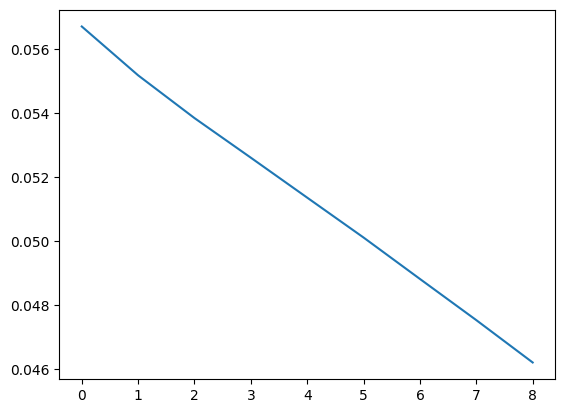

     -------------------val_aucs-------------


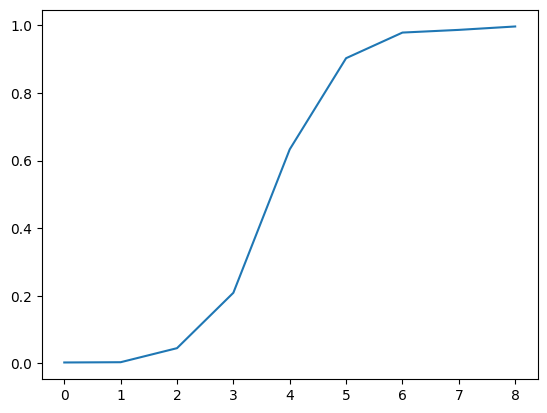

In [5]:
import matplotlib.pyplot as plt
print("     ------------------- Loss ---------------")
plt.plot(train_losses)
plt.show()
print("     -------------------val_aucs-------------")
plt.plot(val_aucs)
plt.show()
